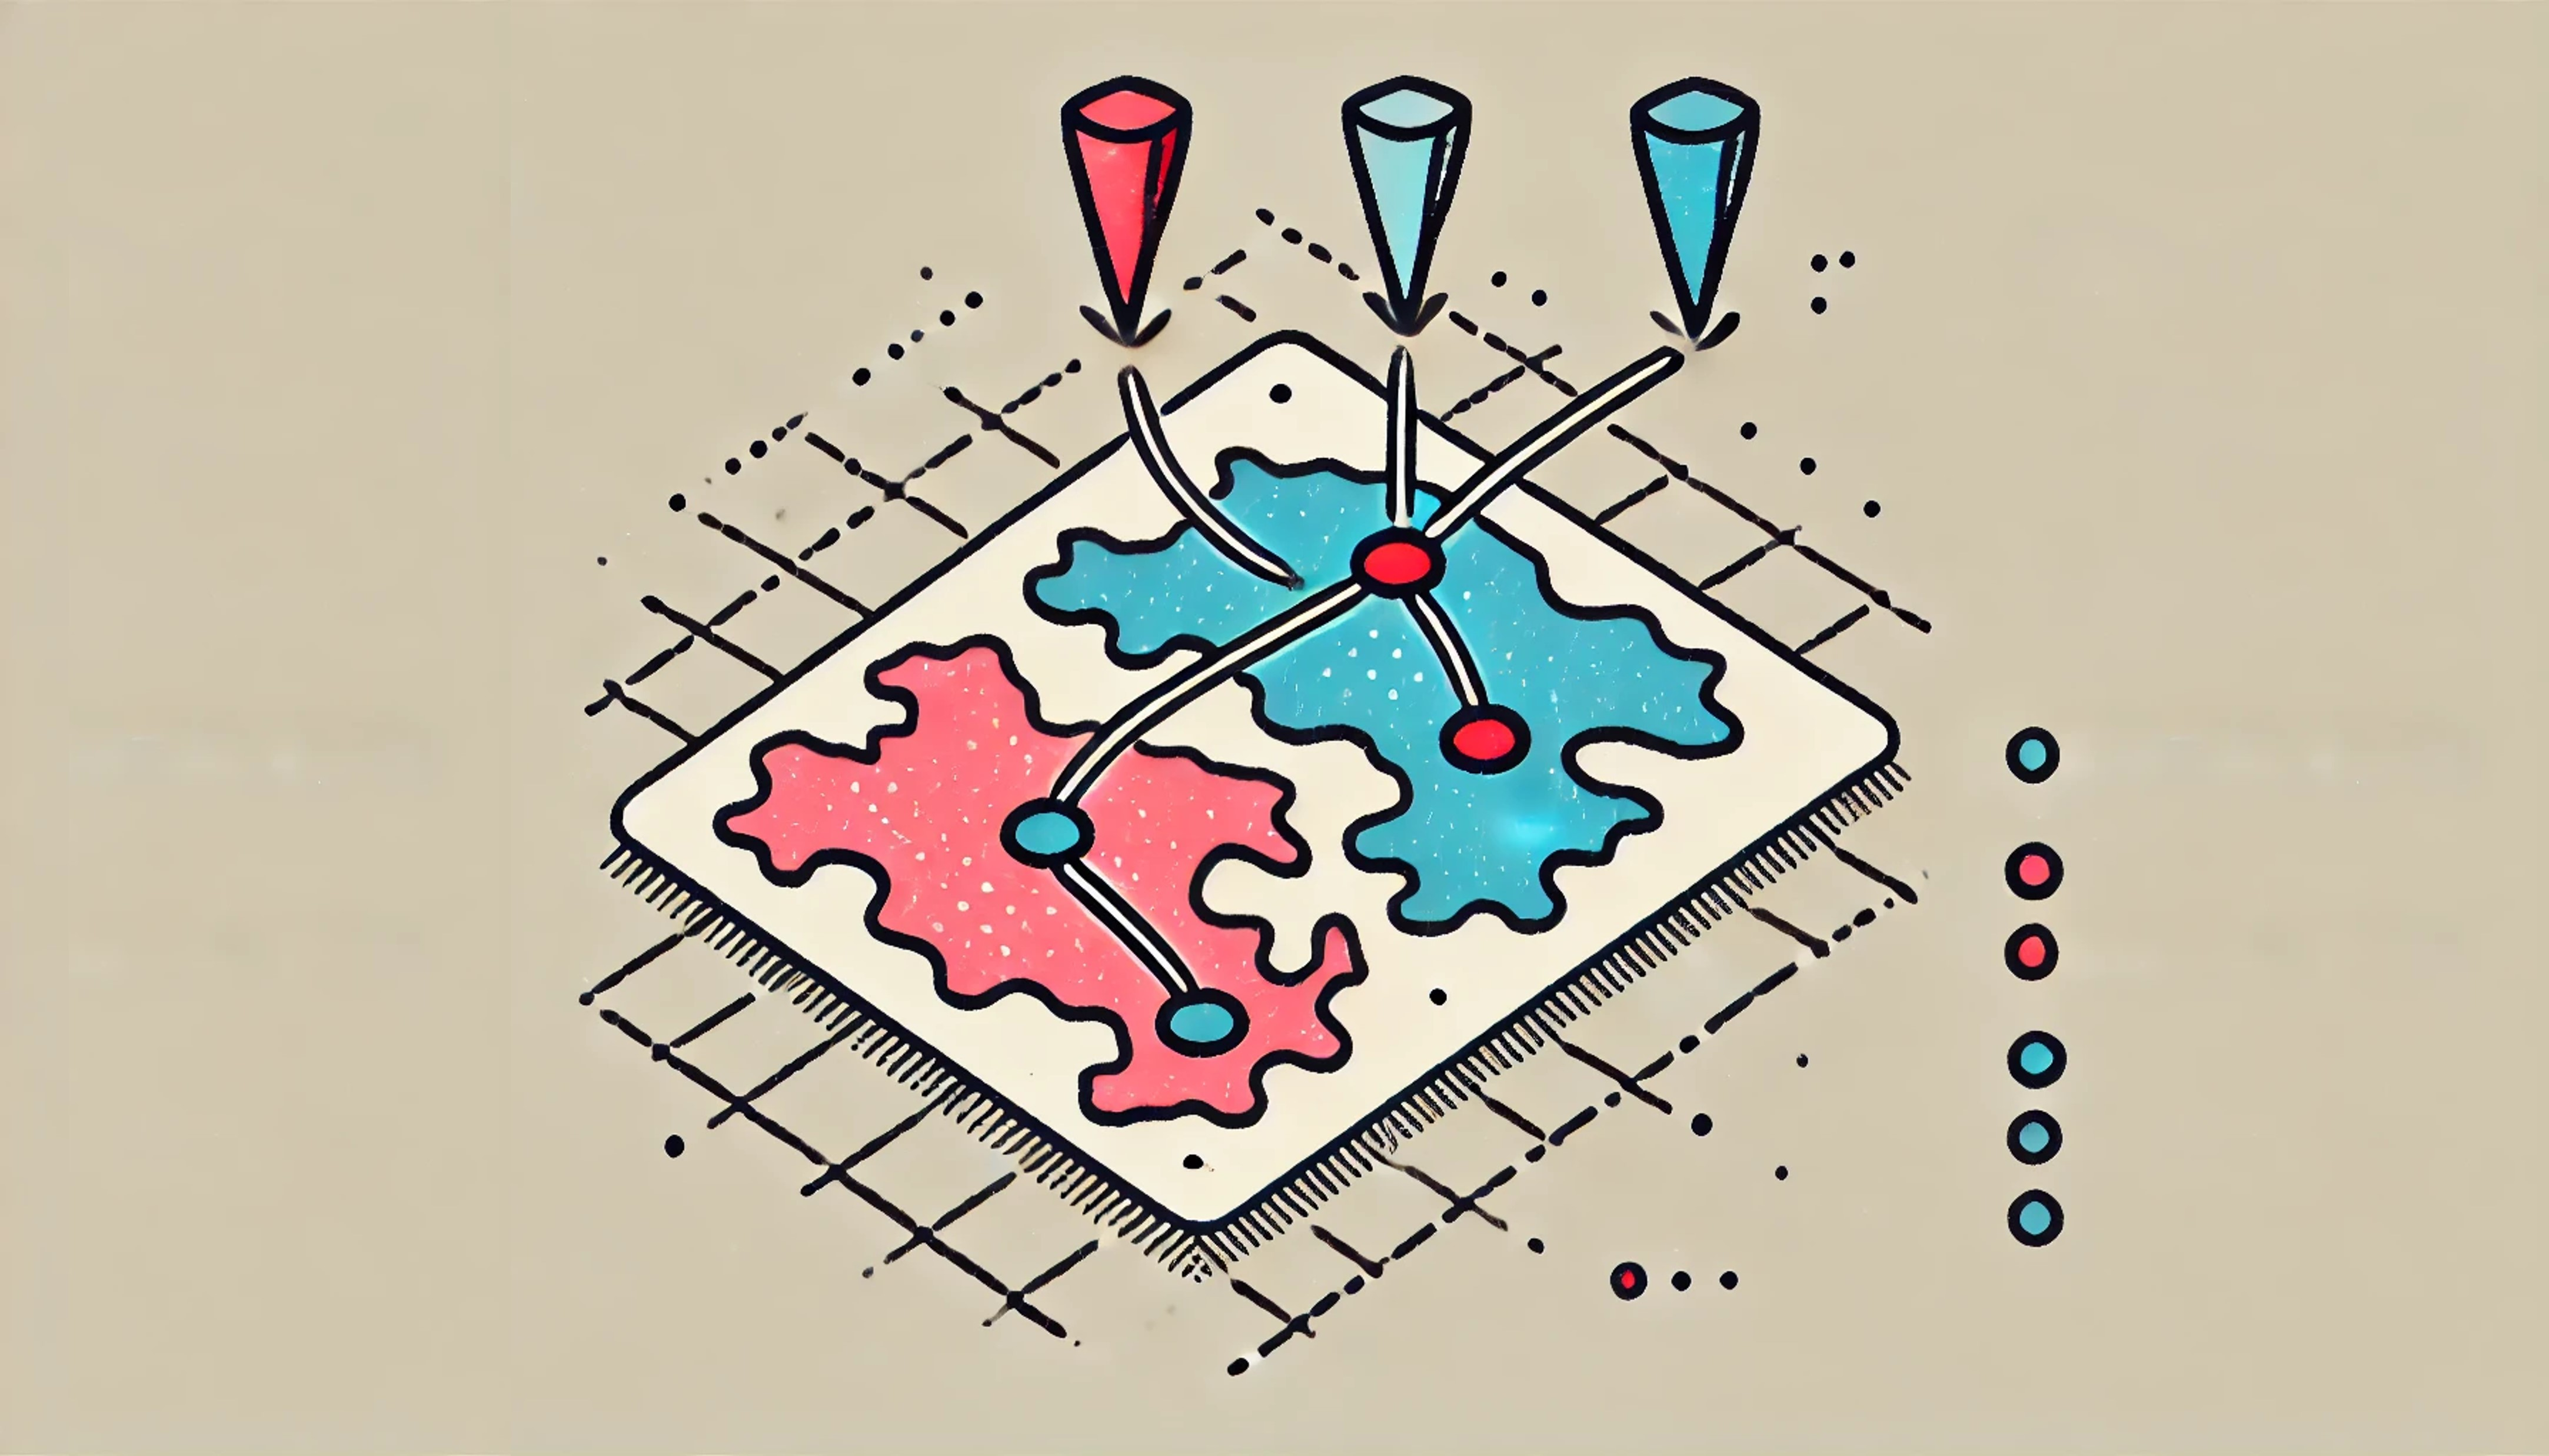

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 1. Purpose🎉 </b></div>

**Given data on the coordinates of a location and a space that represents an area of a country, how can we combine the two?
In this notebook, I explain the spatial combination using `sjoin` in `GeoPandas` along with `Google Map API` additionally.**

<div style="background-color:#f0fae9; padding:6px 20px; border-radius:15px; font-size:20px">
    <br>
    <div style="font-weight:bold;font-size:24px;margin-left:8px;">💡Example</div>
    <div style="font-size:20px;margin-left:16px;">Create a dataset showing where Times Square is located around the world (actually not just in New York).</div>
    <br>
    <div style="font-weight:bold;font-size:24px;margin-left:8px;">💡Direction</div>
    <ul style="font-size:20px;">
      <li>Obtain Times Square coordinate data in the world with Google Map API</li>
      <li>Obtaining spatial(multipolygon) data for each country with GeoPandas</li>
      <li>Combine two data with sjoin</li>
    </ul>
</div>

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 2. Preparation⚙️</b></div>

**You have to get the API key of Google Map from [here](https://developers.google.com/maps/) additionally.**

In [1]:
import pandas as pd
import requests
import geopandas as gpd
from kaggle_secrets import UserSecretsClient

import folium
from folium import Marker

user_secrets = UserSecretsClient()
YOUR_API_KEY = user_secrets.get_secret("GmapAPIkey")

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 3. Get the World of Times Squares🌟</b></div>

In [2]:
def get_times_square_locations(api_key, query='timessquare'):
    # Endpoint Google Places API
    url = f'https://maps.googleapis.com/maps/api/place/textsearch/json'
    location_names = []
    lats = []
    lngs = []
    geos = []
    
    # Place list for search(It was easier to get more results by limiting the search to a specific region.)
    locations_to_search = [
        {'location': '40.7580,-73.9855', 'radius': 50000},  # north america
        {'location': '-16.063049, -59.941218', 'radius': 50000},  # south america
        {'location': '24.182634, 55.213924', 'radius': 50000}, # middle east
        {'location': '56.116630, 25.516148', 'radius': 50000},  # europe
        {'location': '0.942591, 18.697926', 'radius': 50000}, # africa
        {'location': '22.672245, 112.287533', 'radius': 50000}, # asia1
        {'location': '37.572407, 128.221290', 'radius': 50000}   # asia2
    ]
    
    for loc in locations_to_search:
        params = {
            'query': query,
            'location': loc['location'],
            'radius': loc['radius'],
            'type': 'tourist_attraction',
            'key': api_key
        }
        
        while True:
            # API request
            response = requests.get(url, params=params)
            results = response.json().get('results', [])
            # Latitude and Longitude
            for result in results:
                location_names.append(result.get('name'))
                lats.append(result['geometry']['location']['lat'])
                lngs.append(result['geometry']['location']['lng'])
            
            # Next page Token
            next_page_token = response.json().get('next_page_token')
            if not next_page_token:
                break
            
            # Update params
            params['pagetoken'] = next_page_token
    df = pd.DataFrame({'location name':location_names,'latitude':lats,'longitude':lngs})
    return df

# Your API key here
API_KEY = YOUR_API_KEY

# Get the dataframe having the coordinate "times square"
times_square_locations = get_times_square_locations(YOUR_API_KEY)

# Remove duplicates
times_square_locations = times_square_locations.drop_duplicates().reset_index(drop=True)

In [3]:
times_square_locations

,location name,latitude,longitude
0,Times Square,40.757975,-73.985543
1,Times Square 35 Times,40.755376,-73.987443
2,Times Square Billbarod,40.758572,-73.984557
3,Time Square,40.762172,-73.983056
4,Father Duffy Square,40.759008,-73.985022
5,Alserkal Avenue,25.143116,55.224613
6,One Times Square,40.756374,-73.986455
7,Time Square,24.769699,46.602453
8,Times Square,23.146273,113.416544
9,Hongcheon Ginkgo Forest,37.830898,128.469330


There are many locations around 40 degrees latitude and -73 degrees longitude, such as the Times Square area in New York City, which is an institution or some branch stores named after Times Square.

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 4. Get the World Map Data🌟</b></div>

**That's really easy, just use a method of `GeoPandas`**

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

/tmp/ipykernel_18/2073187333.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


<a id="5"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 5. Merge two dataframes with sjoin🌟</b></div>

**For example, when using the merge method in `Pandas`, you select a column as the key and join the data with a common value. Similarly, to join "a place" and "a region," you use the `sjoin` method in `GeoPandas`.**

In [5]:
# Transform to geometry form
g_times_square_locations = gpd.GeoDataFrame(
    times_square_locations, 
    geometry=gpd.points_from_xy(times_square_locations.longitude, times_square_locations.latitude),
    crs="EPSG:4326"
)

# Merge two dataframes 
timessquares = gpd.sjoin(g_times_square_locations, world)
print(timessquares.name.unique())

['United States of America' 'United Arab Emirates' 'Saudi Arabia' 'China'
 'South Korea']


In [6]:
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in timessquares.iterrows():
    Marker([row['latitude'], row['longitude']], popup=row['location name']).add_to(m)
    
m

<div style="background-color:#fbf5e0; padding:12px 20px; border-radius:15px; font-size:18px">
    We can get the dataset of times square in the world with Google Map API and Geopandas.
    <br>
    Btw, the Time Square (not time"s") in Saudi Arabia looks so cooool. Let's check it😊
</div>



# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 0px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  border:#E57C23 solid; color:rgb(34, 34, 34); background-color: #FFFAF0; "><b>Thank you for reading!! Please follow my profiles!!</b>
    
</div>



[![Github](https://img.shields.io/badge/--FFFFFF?style=social&logo=github&label=Follow%20yutowac)](https://github.com/yutowac)


[![LinkedIn](https://img.shields.io/badge/--FFFFFF?style=social&logo=LinkedIn&label=Follow%20yutowac)](https://www.linkedin.com/in/wachi-yuto-b43ab3a2/)